# Testing The Model

## Config

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")

print("Path to dataset files:", path)

100%|██████████| 4.94G/4.94G [03:57<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1


In [3]:
TEST_DIR = "/root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1/Dataset/DIV2K_valid_HR"

import os
import numpy as np
from torchvision import transforms
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# models.py
import torch
from torch import nn

class ResidualBlock(nn.Module):
    """
    A single residual block as defined in the SRGAN paper.
    It contains two convolutional layers with batch normalization and PReLU activation.
    """
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return identity + out

class UpsampleBlock(nn.Module):
    """
    Upsampling block using a convolutional layer and PixelShuffle.
    This increases the resolution by a factor of 2.
    """
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.pixel_shuffle(self.conv(x)))

class Generator(nn.Module):
    """
    The Generator Network (SRResNet).
    It takes a low-resolution image and outputs a super-resolved version.
    """
    def __init__(self, in_channels=3, num_res_blocks=16):
        super(Generator, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.mid_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsampling by 4x (two 2x upsample blocks)
        self.upsample_blocks = nn.Sequential(
            UpsampleBlock(64),
            UpsampleBlock(64),
        )

        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial_out = self.initial_conv(x)
        residual_out = self.residuals(initial_out)
        mid_out = self.mid_conv(residual_out)
        mid_out = mid_out + initial_out # Skip connection
        upsampled_out = self.upsample_blocks(mid_out)
        final_out = self.final_conv(upsampled_out)
        return torch.tanh(final_out) # Tanh activation to scale output to [-1, 1]

class Discriminator(nn.Module):
    """
    The Discriminator Network.
    It takes an image and outputs a probability of it being a real high-resolution image.
    """
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def conv_block(in_feat, out_feat, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_feat),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(64, 64, stride=2),
            conv_block(64, 128, stride=1),
            conv_block(128, 128, stride=2),
            conv_block(128, 256, stride=1),
            conv_block(256, 256, stride=2),
            conv_block(256, 512, stride=1),
            conv_block(512, 512, stride=2),
        )

        # The paper mentions flattening and then two dense layers
        # The output size after convolutions on a 96x96 image is 512x6x6
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Flattens the output
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = self.blocks(x)
        out = self.classifier(out)
        return out.view(batch_size, -1) # No sigmoid here, handled by BCEWithLogitsLoss

In [5]:
from huggingface_hub import hf_hub_download

# Hugging Face model configuration
HF_MODEL_NAME = "keanteng/srgan-div2k-0723"  # Your model name from srgan.ipynb

# Download the generator model
GEN_PATH = hf_hub_download(
    repo_id=HF_MODEL_NAME,
    filename="generator.pth"
)

print(f"Downloaded model to: {GEN_PATH}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


generator.pth:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

Downloaded model to: /root/.cache/huggingface/hub/models--keanteng--srgan-div2k-0723/snapshots/4d44132d5f071c926586b1eb69ea408b04b3ead8/generator.pth


## Inference

In [6]:
# evaluate.py
from torchvision.utils import save_image
from torchvision import transforms
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
#import config
#from models import Generator

def calculate_psnr(img1, img2):
    """
    Calculate PSNR between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert to grayscale if images are color
    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    ssim_value = ssim(img1_gray, img2_gray, data_range=255)
    return ssim_value

def tensor_to_numpy(tensor):
    """
    Convert tensor to numpy array in range [0, 255].
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = tensor * 0.5 + 0.5
    # Clamp to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    # Convert to numpy and scale to [0, 255]
    numpy_img = tensor.squeeze(0).cpu().detach().numpy()
    numpy_img = np.transpose(numpy_img, (1, 2, 0))  # CHW to HWC
    numpy_img = (numpy_img * 255).astype(np.uint8)
    return numpy_img

In [ ]:
def rgb_to_y_channel(img):
    """Convert RGB image to Y channel (luminance)"""
    if len(img.shape) == 3:
        # ITU-R BT.601 conversion
        y = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
        return y.astype(np.uint8)
    return img

def calculate_metrics_paper_protocol(img1, img2):
    """
    Calculate PSNR and SSIM following the original SRGAN paper protocol
    """
    # Convert to Y channel
    y1 = rgb_to_y_channel(img1)
    y2 = rgb_to_y_channel(img2)
    
    # Remove 4-pixel border (center crop)
    h, w = y1.shape
    y1_cropped = y1[4:h-4, 4:w-4]
    y2_cropped = y2[4:h-4, 4:w-4]
    
    # Calculate metrics on Y channel only
    psnr_val = calculate_psnr(y1_cropped, y2_cropped)
    ssim_val = ssim(y1_cropped, y2_cropped, data_range=255)
    
    return psnr_val, ssim_val

In [7]:
def test_original_image(image_path, save_prefix="original"):
    """
    Test the model on an original image without any preprocessing.
    The image will be processed in patches if it's too large.
    """
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_width, original_height = original_image.size

    print(f"Original image size: {original_width} x {original_height}")

    # For very large images, we might need to process in patches
    # For demonstration, let's resize to a manageable size first
    max_size = 512  # Adjust based on your GPU memory

    if max(original_width, original_height) > max_size:
        # Resize while maintaining aspect ratio
        ratio = min(max_size / original_width, max_size / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)
        resized_image = original_image.resize((new_width, new_height), Image.BICUBIC)
        print(f"Resized to: {new_width} x {new_height}")
    else:
        resized_image = original_image
        new_width, new_height = original_width, original_height

    # Ensure dimensions are divisible by 4 (due to 4x upscaling)
    adjusted_width = (new_width // 4) * 4
    adjusted_height = (new_height // 4) * 4

    if adjusted_width != new_width or adjusted_height != new_height:
        resized_image = resized_image.resize((adjusted_width, adjusted_height), Image.BICUBIC)
        print(f"Adjusted to: {adjusted_width} x {adjusted_height}")

    # Create LR version by downsampling by 4x
    lr_width = adjusted_width // 4
    lr_height = adjusted_height // 4
    lr_image = resized_image.resize((lr_width, lr_height), Image.BICUBIC)

    # Convert to tensor and normalize
    lr_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ])
    lr_tensor = lr_transform(lr_image).unsqueeze(0).to(DEVICE)

    # Generate SR image
    gen = Generator().to(DEVICE)
    gen.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
    gen.eval()

    with torch.no_grad():
        sr_tensor = gen(lr_tensor)

    # Convert back to PIL images
    sr_image = transforms.ToPILImage()((sr_tensor.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))

    # Create bicubic upscaled version for comparison
    bicubic_image = lr_image.resize((adjusted_width, adjusted_height), Image.BICUBIC)

    # Save results
    os.makedirs("results", exist_ok=True)
    sr_image.save(f"results/{save_prefix}_sr_result.png")
    bicubic_image.save(f"results/{save_prefix}_bicubic_result.png")
    lr_image.save(f"results/{save_prefix}_lr_input.png")
    resized_image.save(f"results/{save_prefix}_original.png")

    # Display comparison
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title("Low Resolution Input")
    plt.imshow(lr_image)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Bicubic Upscaling")
    plt.imshow(bicubic_image)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("SRGAN Output")
    plt.imshow(sr_image)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Original (Ground Truth)")
    plt.imshow(resized_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return lr_image, bicubic_image, sr_image, resized_image

Original image size: 2040 x 1356
Resized to: 512 x 340


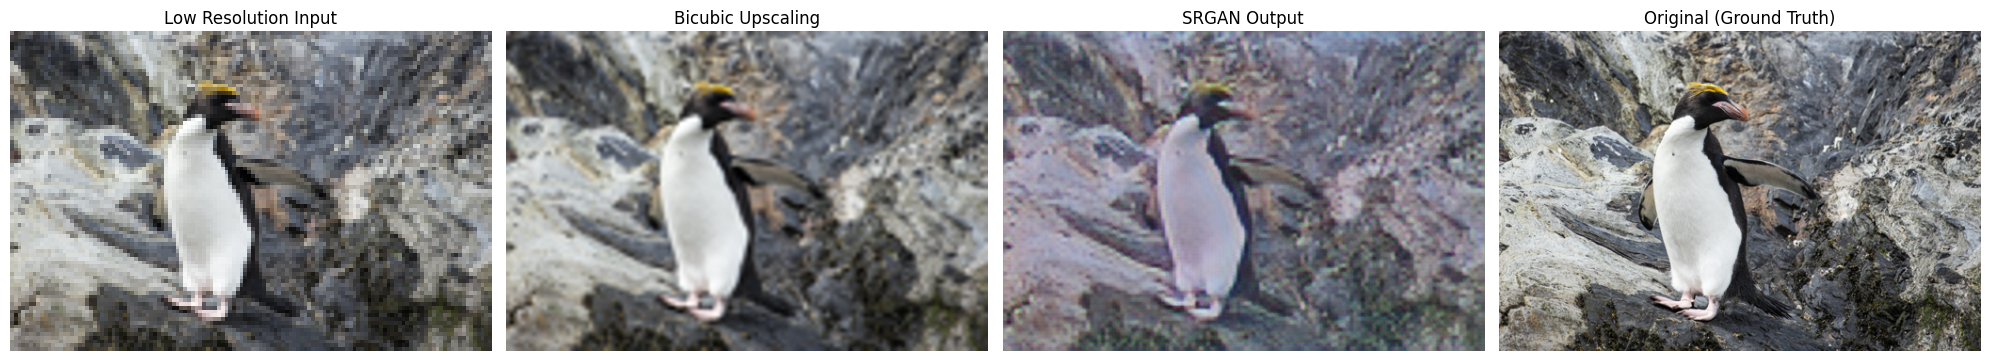

=== Results on Original Image ===
SRGAN vs Original:
  PSNR: 18.48 dB
  SSIM: 0.5490

Bicubic vs Original:
  PSNR: 22.63 dB
  SSIM: 0.5924

Improvement:
  PSNR: +-4.15 dB
  SSIM: +-0.0435


In [ ]:
# Test on an original image
test_image_path = f"{TEST_DIR}/0801.png"  # Use any image path
lr_img, bicubic_img, sr_img, original_img = test_original_image(test_image_path, "test1")

# Calculate metrics if needed
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results on Original Image ===")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

Original image size: 2040 x 1464
Resized to: 512 x 367
Adjusted to: 512 x 364


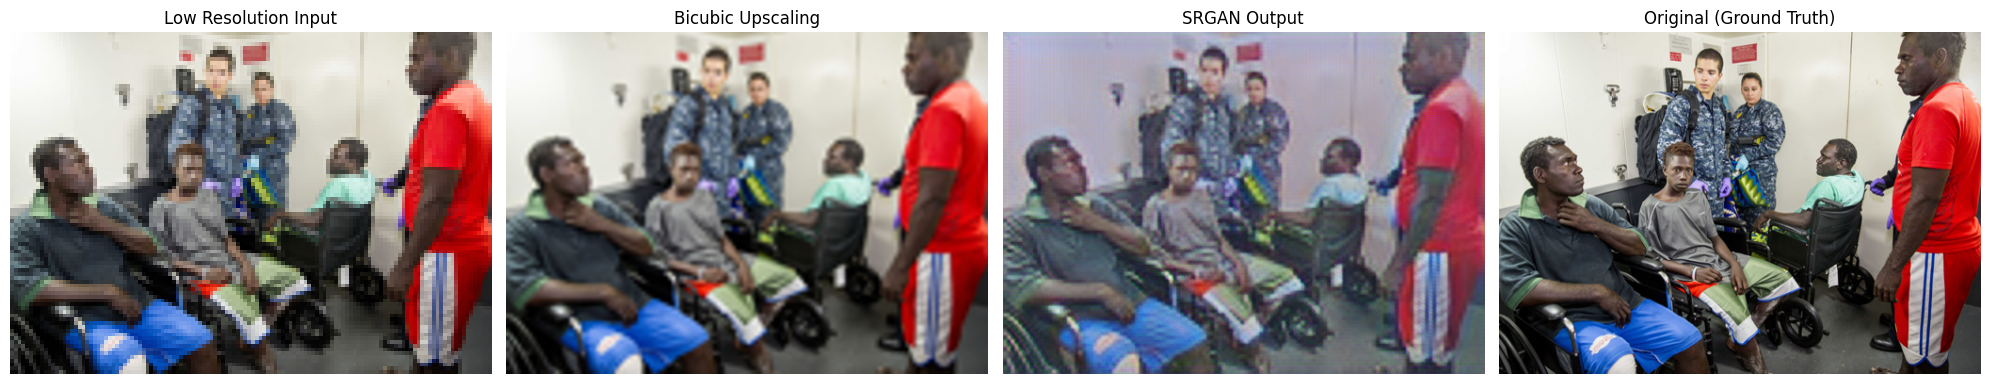

=== Results on Original Image ===
SRGAN vs Original:
  PSNR: 16.32 dB
  SSIM: 0.6573

Bicubic vs Original:
  PSNR: 23.87 dB
  SSIM: 0.7621

Improvement:
  PSNR: +-7.55 dB
  SSIM: +-0.1049


In [ ]:
# Test on an original image
test_image_path = f"{TEST_DIR}/0813.png"  # Use any image path
lr_img, bicubic_img, sr_img, original_img = test_original_image(test_image_path, "test1")

# Calculate metrics if needed
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results on Original Image ===")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

Original image size: 2040 x 1536
Resized to: 512 x 385
Adjusted to: 512 x 384


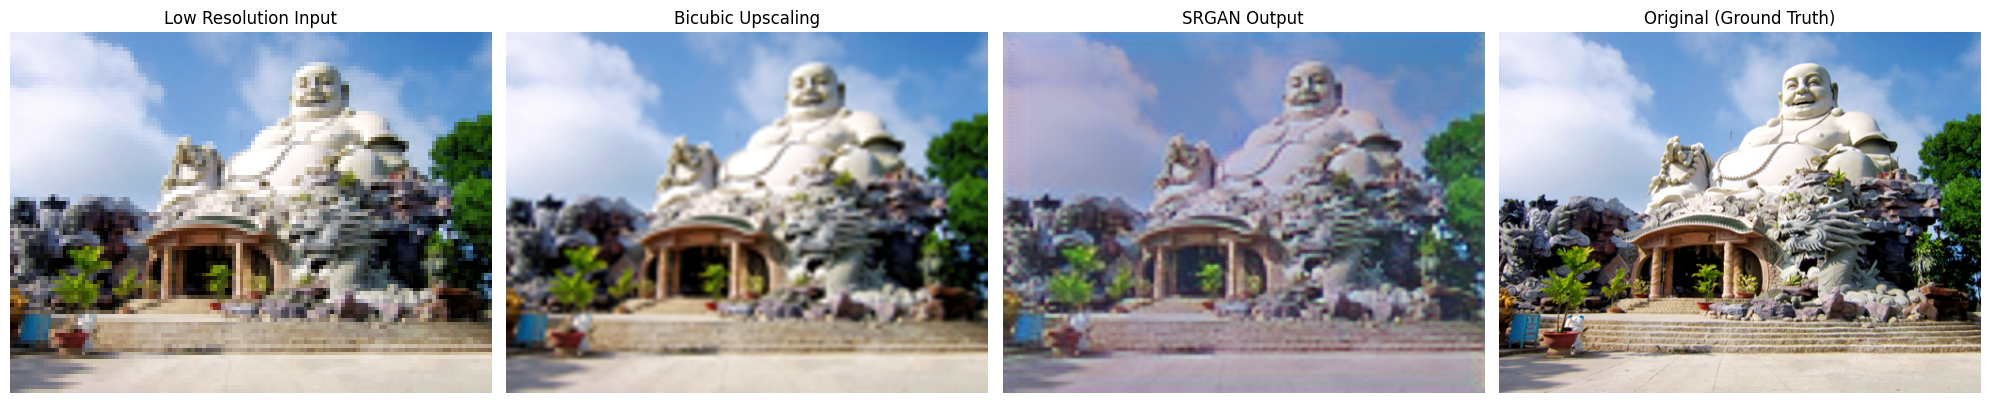

=== Results on Original Image ===
SRGAN vs Original:
  PSNR: 16.43 dB
  SSIM: 0.6518

Bicubic vs Original:
  PSNR: 22.57 dB
  SSIM: 0.7389

Improvement:
  PSNR: +-6.14 dB
  SSIM: +-0.0871


In [ ]:
# Test on an original image
test_image_path = f"{TEST_DIR}/0818.png"  # Use any image path
lr_img, bicubic_img, sr_img, original_img = test_original_image(test_image_path, "test1")

# Calculate metrics if needed
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results on Original Image ===")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")